In [51]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit

df=pd.read_csv('center_sternum.txt',sep='\t')

df['Time']=np.arange(0,len(df['qi']))/200
%matplotlib inline

## AccX

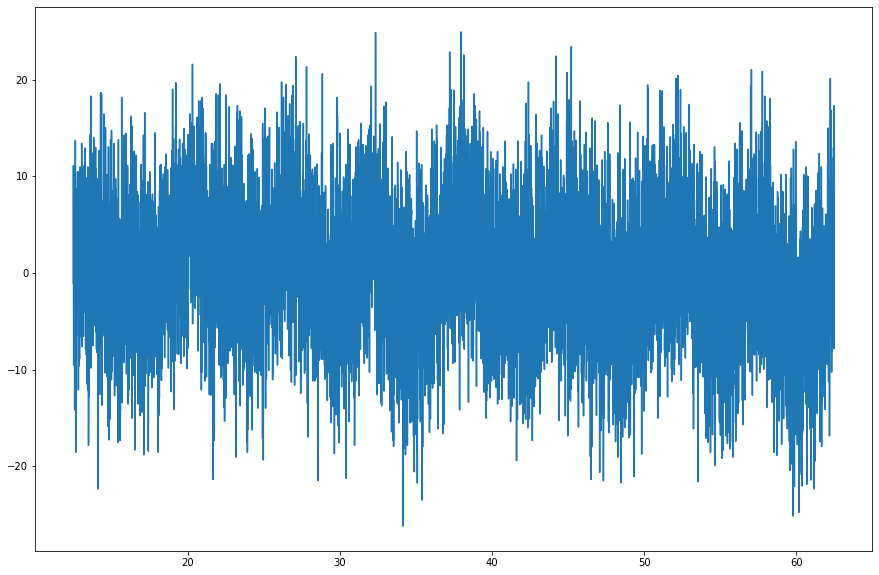

In [2]:
plt.figure(figsize=(15,10))
plt.plot(df['Time'].iloc[2500:12500],df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]))
#plt.xlim(20,21)

(0.0, 8000.0)

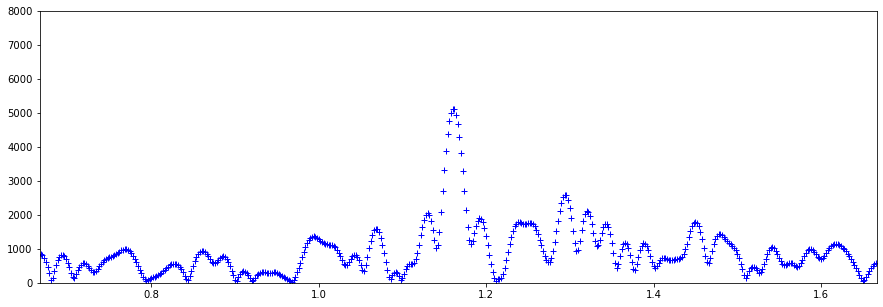

In [52]:
accxfreq=np.fft.fft(df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]),n=100000)
freq=np.fft.fftfreq(d=1/200, n=100000)

#select heart-beat freq
min_f=40./60.
max_f=100./60.

plt.figure(figsize=(15,5))
plt.plot(freq,np.abs(accxfreq),'b+')
plt.xlim(min_f, max_f)
plt.ylim(0,8000)
#plt.xlim(8, 25)

Gaussian mean:	 69.65920946632885 BPM -0.7039367174877363


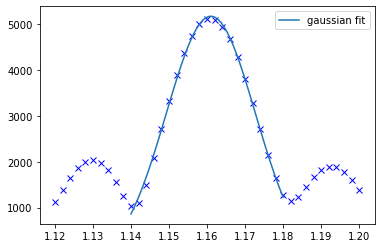

In [53]:
#for finding with gaussian interpolation the peak and his frequency-value
min_f=40./60.
max_f=100./60.

def trasf_grad(freq,mean,A,T,h): #with abs value!!
    return np.abs((A/(np.pi*(freq-mean))) * np.sin(np.pi*(freq-mean)*T))+h

def gauss(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + offset

def find_peak (x,y,height_peak,p0_gauss,range_points): #NB change p0 and height
    x_heart=[]
    y_heart=[]
    for i in range(len(x)):
        if x[i]<=max_f and x[i]>=min_f:
            x_heart.append(x[i])
            y_heart.append(y[i])
        
    peaks,_ = signal.find_peaks(y_heart, height=height_peak)
    for i in peaks:
        plt.plot(x_heart[i-range_points:i+range_points+1],y_heart[i-range_points:i+range_points+1],'bx')
        
        global popt
        popt,pcov = curve_fit(gauss,x_heart[i-range_points//2:i+range_points//2+1],y_heart[i-range_points//2:i+range_points//2+1],p0=p0_gauss, maxfev = 3000)
        x_fit=np.linspace(x_heart[i-range_points//2],x_heart[i+range_points//2])
        plt.plot(x_fit,gauss(x_fit,*popt),label='gaussian fit')
        print('Gaussian mean:\t',popt[1]*60,'BPM',popt[2]*60)
        
        #global popt2
        #popt2,pcov2 = curve_fit(trasf_grad,x_heart[i-range_points:i+range_points+1],y_heart[i-range_points:i+range_points+1],p0=[popt[1],4000,10,1000], maxfev = 3000)
        #x_fit2=np.linspace(x_heart[i-20],x_heart[i+20])
        #plt.plot(x_fit2,trasf_grad(x_fit2,*popt2),label='abs curve fit')        
        plt.legend()
        #print('Parameters:\t',popt2)
        
find_peak(freq,np.abs(accxfreq),3000,[4000,1.16,0.03, 1000],20)

<IPython.core.display.Javascript object>


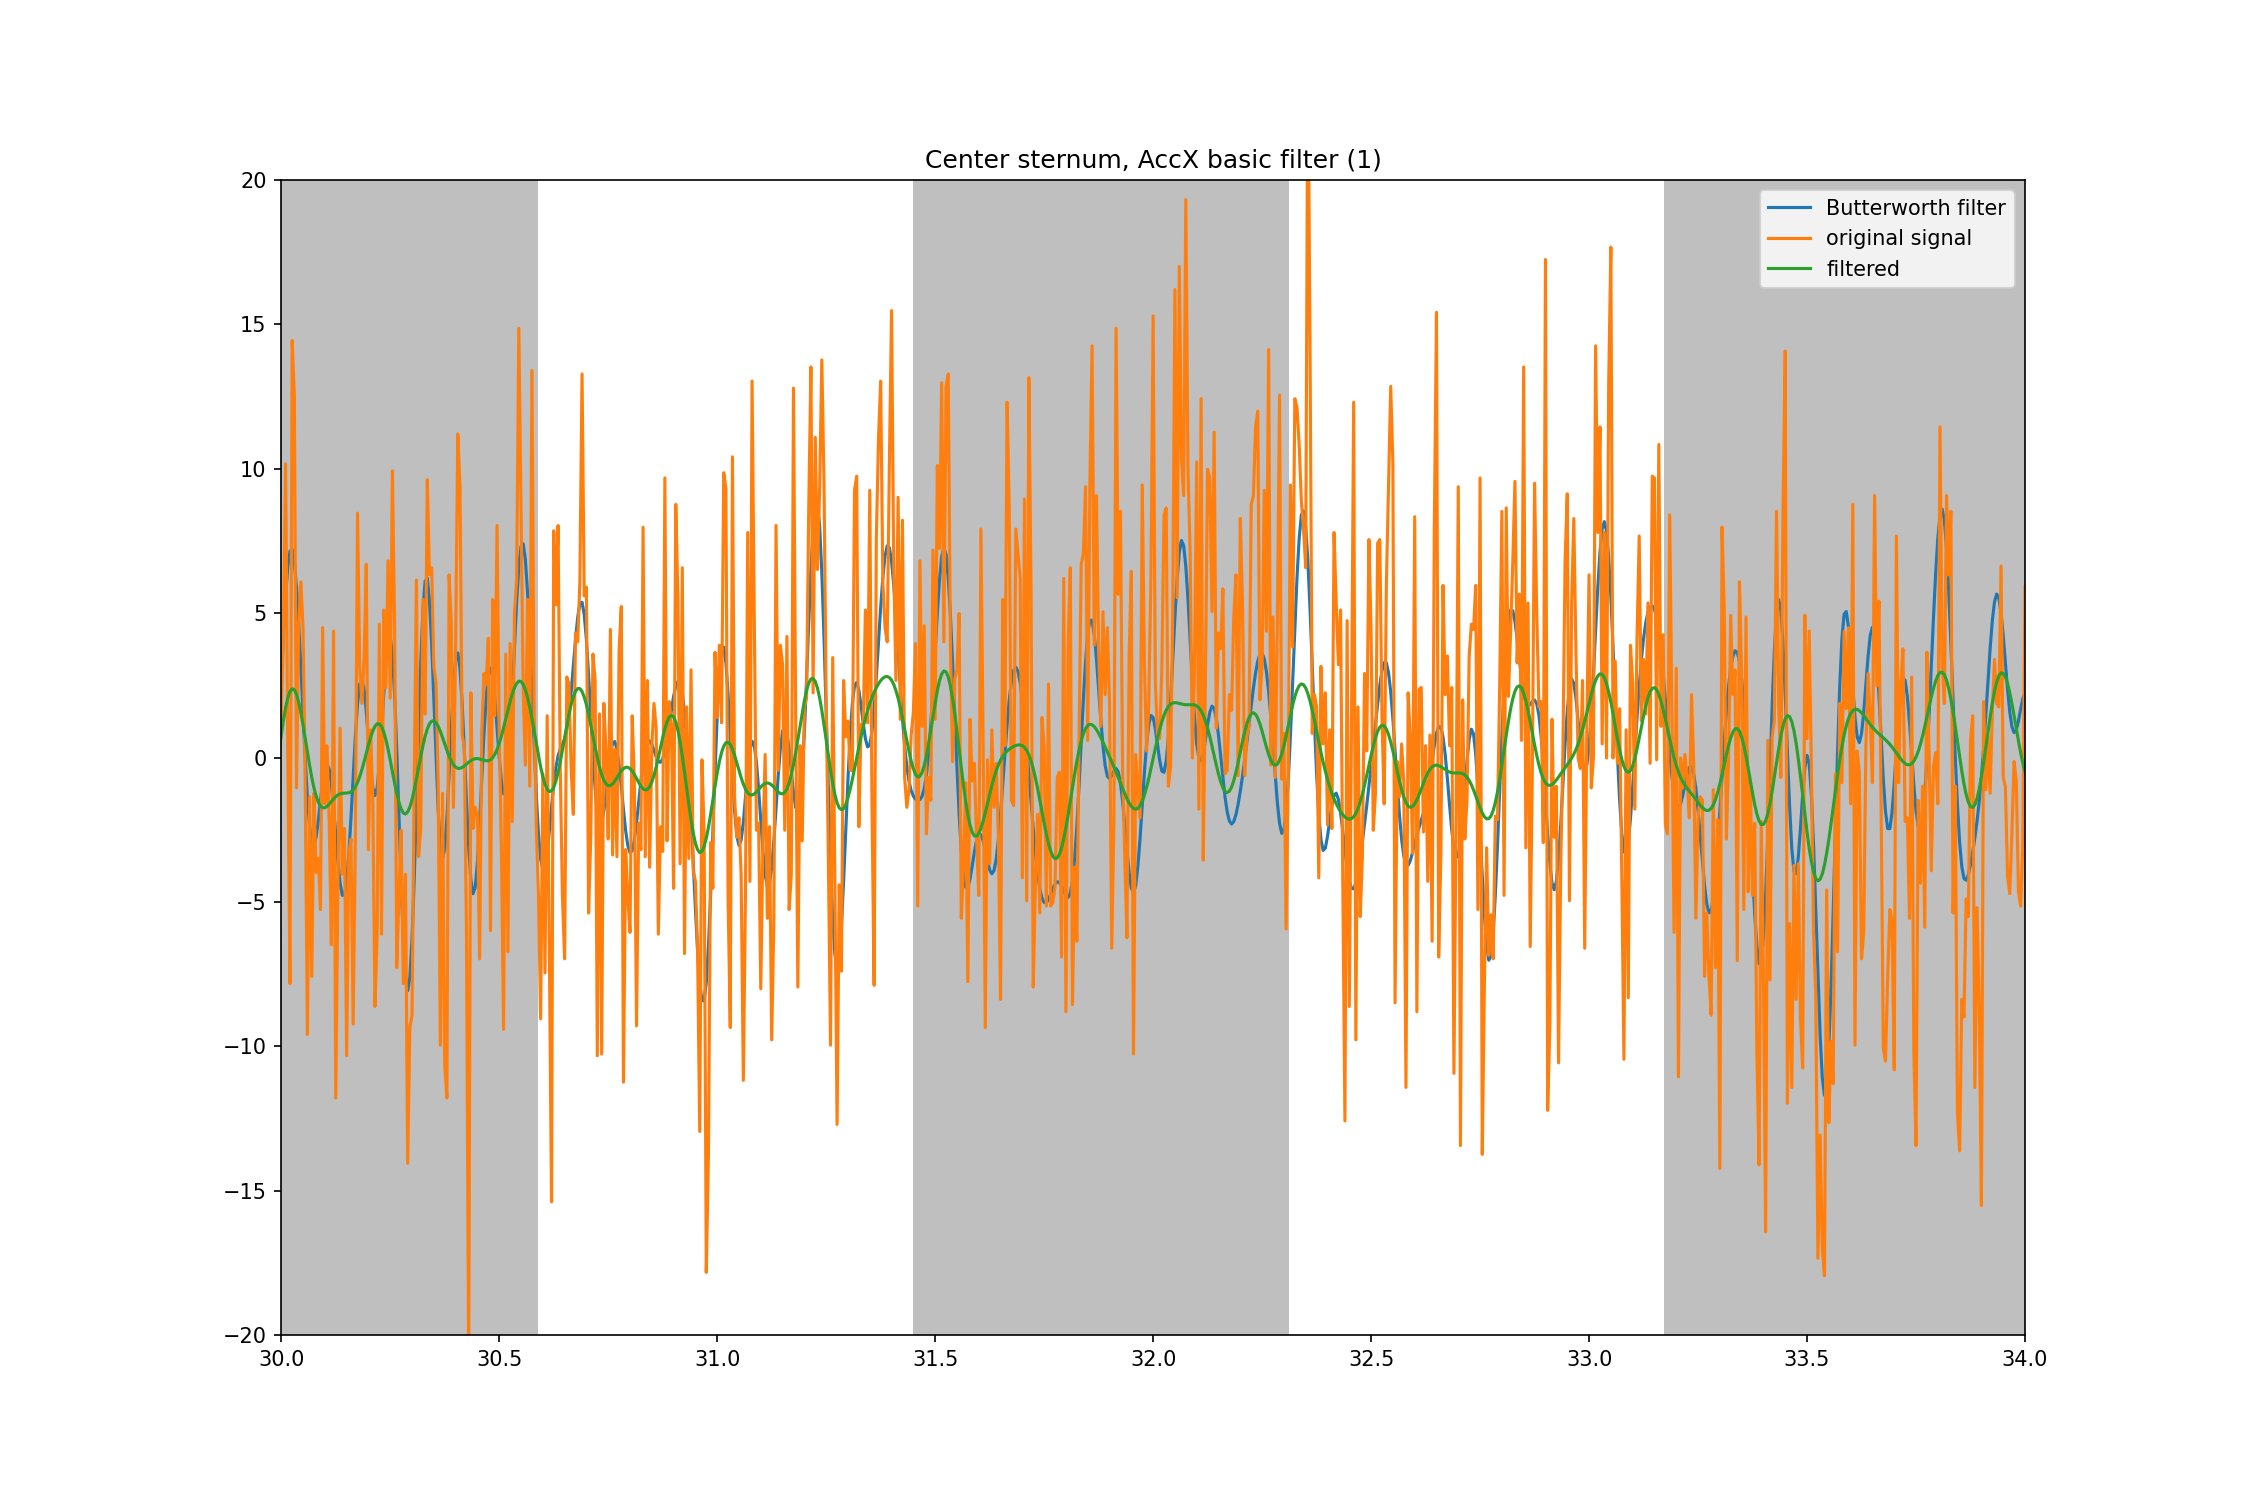

30


C:\Users\Elena\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:

accxfreq=np.fft.fft(df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]))
freq=np.fft.fftfreq(d=1/200, n=len(accxfreq))

cut_signal = accxfreq.copy()
cut_signal[(freq<popt[1]-0.1)]= 0 
#for i in range(int(popt[1]+0.1),15): cut_signal[i]=0
cut_signal[(freq>10)]= 0 

cut_signal_inverse = np.fft.ifft(cut_signal)

fig,ax=plt.subplots(1,1,figsize=(15,10))



#fc = 35 
#w = fc / (200 / 2) #cut-off frequency
b, a = signal.butter(5, Wn=[(popt[1]-0.1)*0.01,15*0.01], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]))


plt.plot(df['Time'].iloc[2500:12500],filtered_data_butterworth, label='Butterworth filter')


plt.plot(df['Time'].iloc[2500:12500],df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]),label='original signal')
plt.plot(df['Time'].iloc[2500:12500],cut_signal_inverse,label='filtered')
plt.legend()
plt.title('Center sternum, AccX basic filter (1)')

x=np.arange(df['Time'].iloc[2500],popt[1]*44+df['Time'].iloc[2500],2/popt[1])
print(len(x))
for i in x:
    plt.axvspan(i, i+1/popt[1], facecolor='gray', alpha=0.5)#distanza in indici!!

#plt.xlim(df['Time'].iloc[2500],df['Time'].iloc[12500])
plt.xlim(30,34)
plt.ylim(-20,20)
plt.show()

<IPython.core.display.Javascript object>


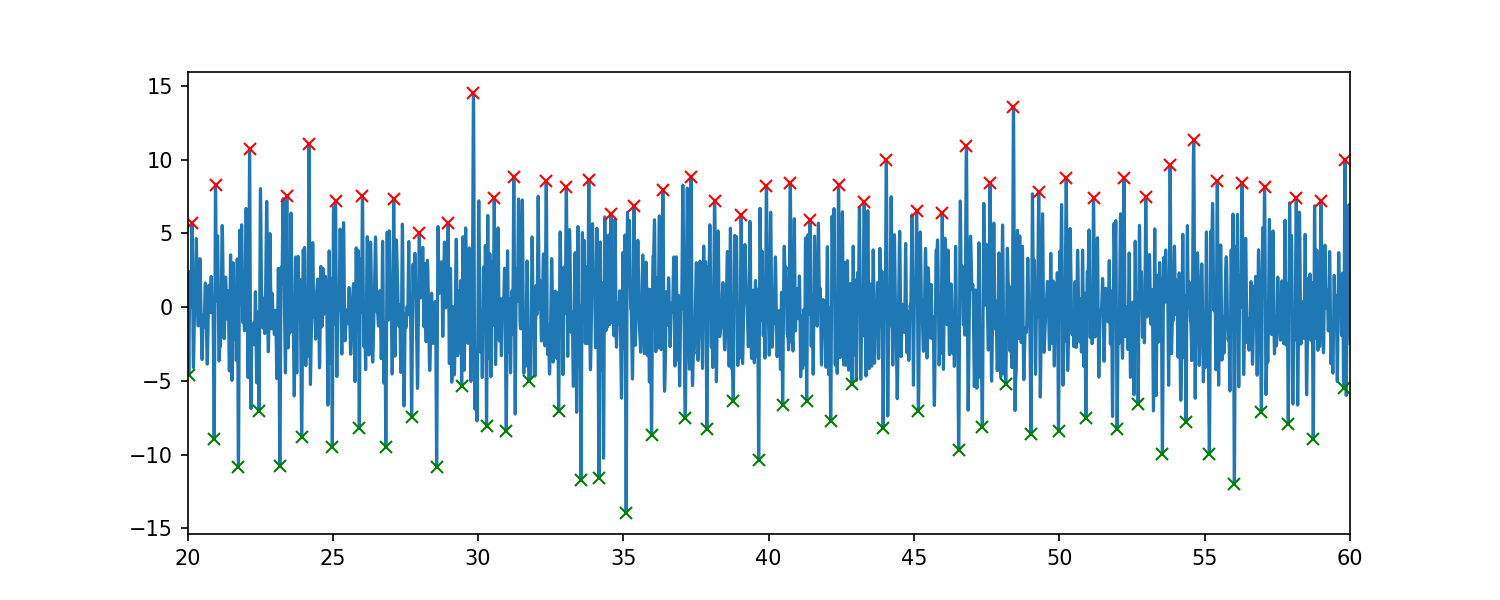

(20.0, 60.0)

In [44]:

sign = filtered_data_butterworth


plt.figure(figsize=(10,4))
data = sign 
plt.plot(df['Time'].iloc[2500:12500].values,data)
peaks,_ = signal.find_peaks(data, height=4 , distance=120,threshold=None, prominence=None)
#print(peaks)
plt.plot(df['Time'].iloc[2500:12500].values[peaks],data[peaks], 'rx')
#plt.ylim(0,4)
peaks2,_=signal.find_peaks(-data, height=4, distance=120)
plt.plot(df['Time'].iloc[2500:12500].values[peaks2],data[peaks2], 'gx')
plt.xlim(20,60)

<IPython.core.display.Javascript object>


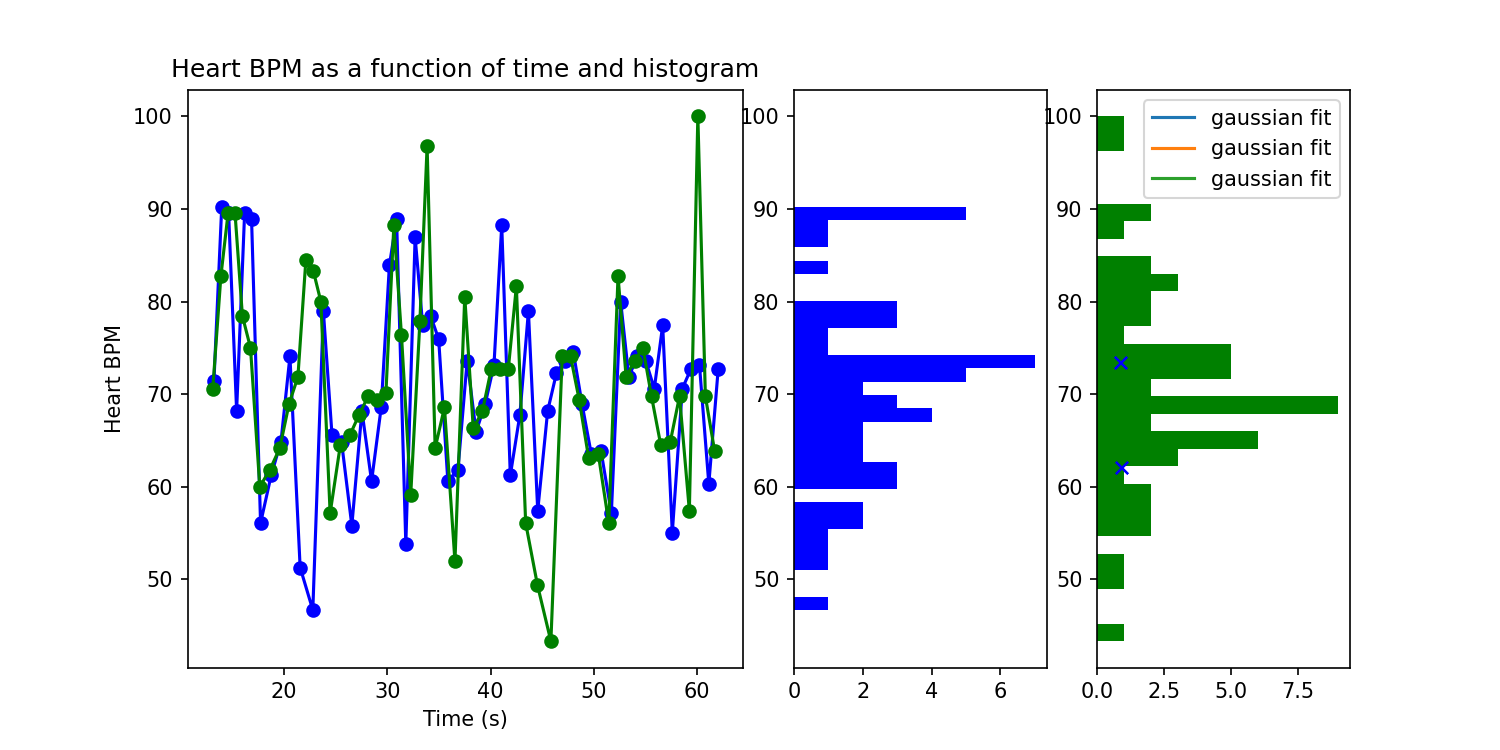

69.99508986237973 2.0351964985752495
10.38313866105787 2.1738393143777333


In [45]:
from lmfit.models import GaussianModel
def histo_func(bins,bins2):
    from matplotlib.gridspec import GridSpec
    peaks_time=df['Time'].iloc[2500:12500].values[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    rate = 1/period*60

    peaks_time2=df['Time'].iloc[2500:12500].values[peaks2]
    period2 = peaks_time2[1:]-peaks_time2[:-1]
    rate2 = 1/period2*60

    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(3,4)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_marg2 = fig.add_subplot(gs[:,3])
    ax_main.plot((peaks_time[1:]+peaks_time[:-1])*0.5,rate,'b-o')
    ax_main.plot((peaks_time2[1:]+peaks_time2[:-1])*0.5,rate2,'g-o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()

    h,b,_=ax_marg.hist(x=rate, bins=bins,orientation='horizontal', color='blue')
    bin_center=(b[1:]+b[:-1])*0.5
    ax_marg.set_ylim(l)

    h2,b2,_=ax_marg2.hist(x=rate2, bins=bins2,orientation='horizontal', color='green')
    bin_center2=(b2[1:]+b2[:-1])*0.5
    ax_marg2.set_ylim(l)

    mod = GaussianModel(prefix='g_')
    pars = mod.guess(h, x=bin_center)
    out = mod.fit(h, pars, x=bin_center)
    #print(out.params)
    #ax_marg.plot(out.best_fit, bin_center, 'r-', label='best fit')
    print(out.params['g_center'].value, out.params['g_center'].stderr)
    print(out.params['g_sigma'].value, out.params['g_sigma'].stderr)
    
histo_func(30,30)

(1.0, 1.4)

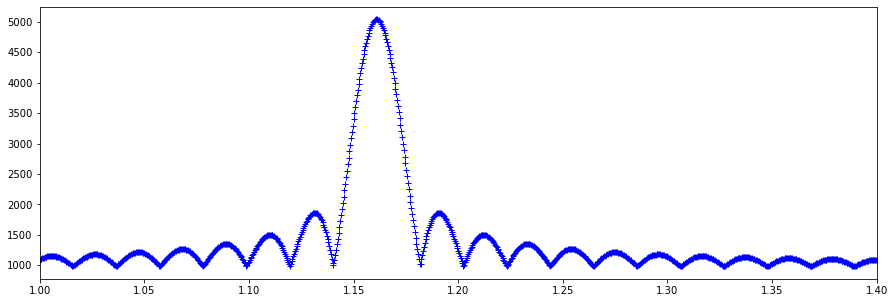

In [11]:
accxfreq=np.fft.fft(df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]),n=500000)
freq=np.fft.fftfreq(d=1/200, n=len(accxfreq))

new_y_freq=trasf_grad(freq,popt2[0],popt2[1],popt2[2],popt2[3])
#new_y_freq[(freq>1.2)]=0
#new_y_freq[(freq<1.12)]=0

plt.figure(figsize=(15,5))
plt.plot(freq,new_y_freq,'b+')
plt.xlim(1,1.4)
#plt.ylim(980,990)

C:\Users\Elena\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(12.5, 12.515)

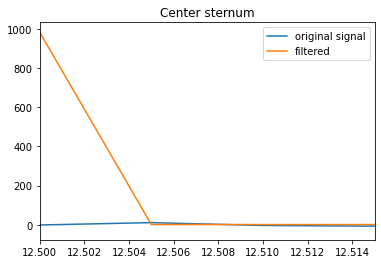

In [60]:
accxfreq=np.fft.fft(df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]))
freq=np.fft.fftfreq(d=1/200,n=len(accxfreq))

new_y_freq=trasf_grad(freq,popt2[0],popt2[1],popt2[2],popt2[3])


new_y_time=np.fft.ifft(new_y_freq)

plt.plot(df['Time'].iloc[2500:12500],df['AccX'].iloc[2500:12500]-np.mean(df['AccX'].iloc[2500:12500]),label='original signal')
plt.plot(df['Time'].iloc[2500:12500],new_y_time,label='filtered')
plt.legend()
plt.title('Center sternum')
plt.xlim(df['Time'].iloc[2500],df['Time'].iloc[2503])

## GyroX

(0.0, 3000.0)

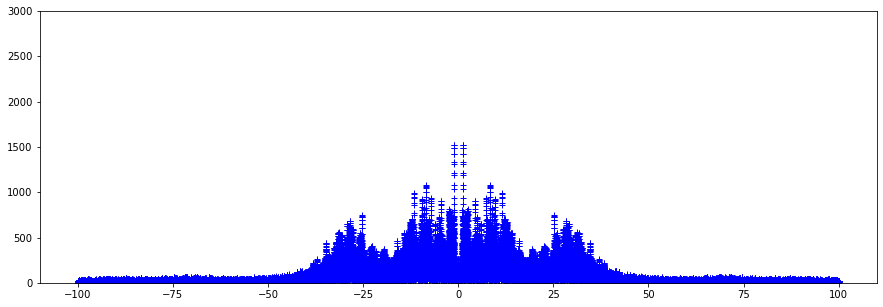

In [19]:
accxfreq=np.fft.fft(df['GyroX'].iloc[2500:12500]-np.mean(df['GyroX'].iloc[2500:12500]),n=100000)
freq=np.fft.fftfreq(d=1/200, n=100000)

#select heart-beat freq
min_f=40./60.
max_f=100./60.

plt.figure(figsize=(15,5))
plt.plot(freq,np.abs(accxfreq),'b+')
#plt.xlim(min_f, max_f)
plt.ylim(0,3000)
#plt.xlim(0, 15)

Gaussian mean:	 69.56462165115562 BPM


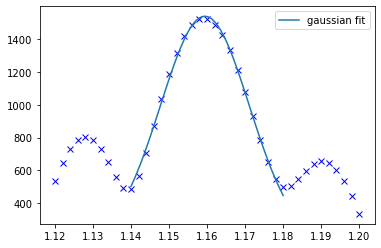

In [10]:
#for finding with gaussian interpolation the peak and his frequency-value
min_f=40./60.
max_f=100./60.

        
find_peak(freq,np.abs(accxfreq),1000,[1000,1.16,0.03, 100],20)

C:\Users\Elena\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


30


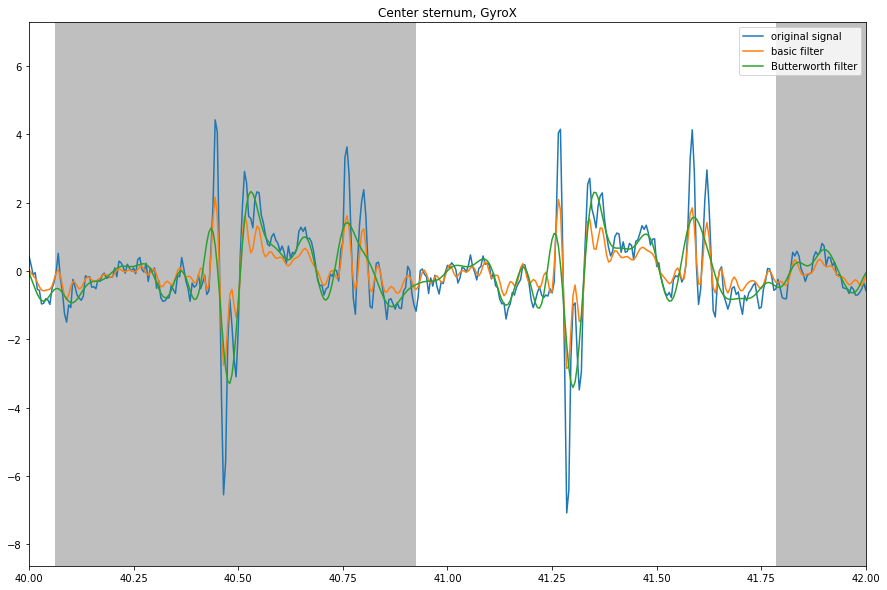

In [39]:
accxfreq=np.fft.fft(df['GyroX'].iloc[2500:12500]-np.mean(df['GyroX'].iloc[2500:12500]))
freq=np.fft.fftfreq(d=1/200, n=len(accxfreq))

#freq around 30 are the ones of the QRS beat (total <0.1 s: here = 0.04)

#filter hb + 15-35

cut_signal = accxfreq.copy()
cut_signal[(freq<popt[1]-0.1)]= 0 
#cut_signal[(freq>6)]= 0 
#cut_signal[(freq<4)]= 0 
cut_signal[(freq>35)]= 0 
#for i in range(int(popt[1]+0.1),15): cut_signal[i]=0

cut_signal_inverse = np.fft.ifft(cut_signal)

fig,ax=plt.subplots(1,1,figsize=(15,10))
 

plt.plot(df['Time'].iloc[2500:12500],df['GyroX'].iloc[2500:12500]-np.mean(df['GyroX'].iloc[2500:12500]),label='original signal')
plt.plot(df['Time'].iloc[2500:12500],cut_signal_inverse,label='basic filter')



#fc = 35 
#w = fc / (200 / 2) #cut-off frequency
b, a = signal.butter(5, Wn=[(popt[1]-0.1)*0.01,15*0.01], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, df['GyroX'].iloc[2500:12500]-np.mean(df['GyroX'].iloc[2500:12500]))


plt.plot(df['Time'].iloc[2500:12500],filtered_data_butterworth, label='Butterworth filter')



x=np.arange(df['Time'].iloc[2500],popt[1]*44+df['Time'].iloc[2500],2/popt[1])
print(len(x))
for i in x:
    plt.axvspan(i, i+1/popt[1], facecolor='gray', alpha=0.5)#distanza in indici!!

#plt.xlim(df['Time'].iloc[2500],df['Time'].iloc[12500])
plt.xlim(40,42)
plt.legend()
plt.title('Center sternum, GyroX')
plt.show()